<a href="https://colab.research.google.com/github/MariaSparrow/Solyanka_IT/blob/main/main/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install MLForecast -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.4 MB/s eta 0:00:00


# Загрузка и настройка библиотек

In [2]:
import pandas as pd
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.shift import shift_array
from window_ops.rolling import rolling_mean

from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences, LocalStandardScaler
from sklearn.linear_model import LinearRegression
import random
from utilsforecast.plotting import plot_series
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.ticker as ticker
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pprint

pd.set_option("display.max_columns", 50)


In [3]:
!gdown 1sIPftXTN3GS3EYxawZaVO5-FQ3lAdNFa

Downloading...
From: https://drive.google.com/uc?id=1sIPftXTN3GS3EYxawZaVO5-FQ3lAdNFa
To: /content/tradestats.csv
100% 5.11M/5.11M [00:00<00:00, 85.9MB/s]


In [4]:
try:
  tradestats = pd.read_csv('/content/tradestats.csv').drop(columns='Unnamed: 0')
except:
  tradestats = pd.read_csv('/content/tradestats.csv')

In [5]:
tradestats.iloc[:2,:]

,trade_code,bigfield,tradedate,ticker,val_b,val_s,vol_b,vol_s,pr_vwap_b_mean,pr_vwap_s_mean,pr_vwap_mean,pr_vwap_median,pr_vwap_var,pr_open_mean,pr_open_median,pr_open_var
0,ABIO,Потребсектор,2023-08-17,ABIO,18969613.0,22262787.0,17184,20217,110.434600,110.3440,110.396827,110.39,0.362812,110.410000,110.43,0.346462
1,ABIO,Потребсектор,2023-08-18,ABIO,19337922.0,20074354.0,17530,18349,110.053462,109.7736,109.886538,109.96,0.547819,109.926346,110.04,0.545190


In [6]:
tradestats['tradedate'] = pd.to_datetime(tradestats['tradedate'])


In [7]:
enc = LabelEncoder()
tradestats['bigfield_enc'] = enc.fit_transform(tradestats['bigfield'])

In [8]:
tradestats[['bigfield_enc', 'bigfield']].drop_duplicates()

,bigfield_enc,bigfield
0,3,Потребсектор
80,9,транспорт
562,7,Химпром
834,1,Металлы и добыча
1562,2,Нефтегаз
2045,6,Финансы
2770,0,ИТ
3024,8,Электроэнергетика
3765,4,Строительные
9478,5,Телекоммуникации


# EDA

In [9]:
tradestats.isna().sum().sort_values()

trade_code        0
pr_open_median    0
pr_open_mean      0
pr_vwap_var       0
pr_vwap_median    0
pr_vwap_mean      0
pr_vwap_s_mean    0
pr_open_var       0
pr_vwap_b_mean    0
vol_b             0
val_s             0
val_b             0
ticker            0
tradedate         0
bigfield          0
vol_s             0
bigfield_enc      0
dtype: int64

In [10]:
tradestats.describe()

,val_b,val_s,vol_b,vol_s,pr_vwap_b_mean,pr_vwap_s_mean,pr_vwap_mean,pr_vwap_median,pr_vwap_var,pr_open_mean,pr_open_median,pr_open_var,bigfield_enc
count,2.425800e+04,2.425800e+04,2.425800e+04,2.425800e+04,24258.000000,24258.000000,24258.000000,24258.000000,2.425800e+04,24258.000000,24258.000000,2.425800e+04,24258.00000
mean,2.023043e+08,1.994304e+08,2.356523e+05,2.342330e+05,2904.127125,2901.617832,2902.723847,2902.813962,9.858514e+03,2902.876898,2902.912388,9.973500e+03,4.52259
std,7.753102e+08,7.666317e+08,8.917483e+05,8.672996e+05,12969.380981,12958.610674,12963.328815,12964.768865,3.226938e+05,12963.921035,12965.029328,3.226331e+05,2.89672
min,8.720000e+03,1.082500e+04,2.000000e+00,3.000000e+00,0.002744,0.002726,0.002736,0.002734,4.328431e-11,0.002737,0.002735,4.200089e-11,0.00000
25%,6.417530e+06,6.995529e+06,6.927250e+03,7.574500e+03,25.487143,25.461641,25.471752,25.460000,7.734150e-03,25.478558,25.461875,8.114603e-03,2.00000
50%,2.888569e+07,3.031503e+07,3.328900e+04,3.457150e+04,158.565702,158.425288,158.477356,158.400000,6.045681e-01,158.510577,158.425000,6.165945e-01,4.00000
75%,1.425309e+08,1.430671e+08,1.505170e+05,1.524928e+05,618.295768,617.791226,618.085634,618.100000,1.313589e+01,618.134270,618.000000,1.339640e+01,7.00000
max,3.584840e+10,3.586247e+10,5.269000e+07,5.215200e+07,144059.711538,143981.442308,144020.586538,143851.000000,4.248939e+07,144060.576923,143900.000000,4.229299e+07,9.00000


In [11]:
tradestats['tradedate'].max(), tradestats['tradedate'].min()

(Timestamp('2023-12-08 00:00:00'), Timestamp('2022-06-01 00:00:00'))

In [12]:
len(tradestats['trade_code'].unique())

96

# Подготовка датасета

In [13]:
dict_cols = {'trade_code':'unique_id',
             'tradedate':'ds',
             'pr_vwap_mean':'y'}
df = tradestats[['trade_code', 'tradedate',
                 'pr_vwap_mean', 'bigfield_enc']].rename(columns=dict_cols)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24258 entries, 0 to 24257
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   unique_id     24258 non-null  object        
 1   ds            24258 non-null  datetime64[ns]
 2   y             24258 non-null  float64       
 3   bigfield_enc  24258 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 758.2+ KB


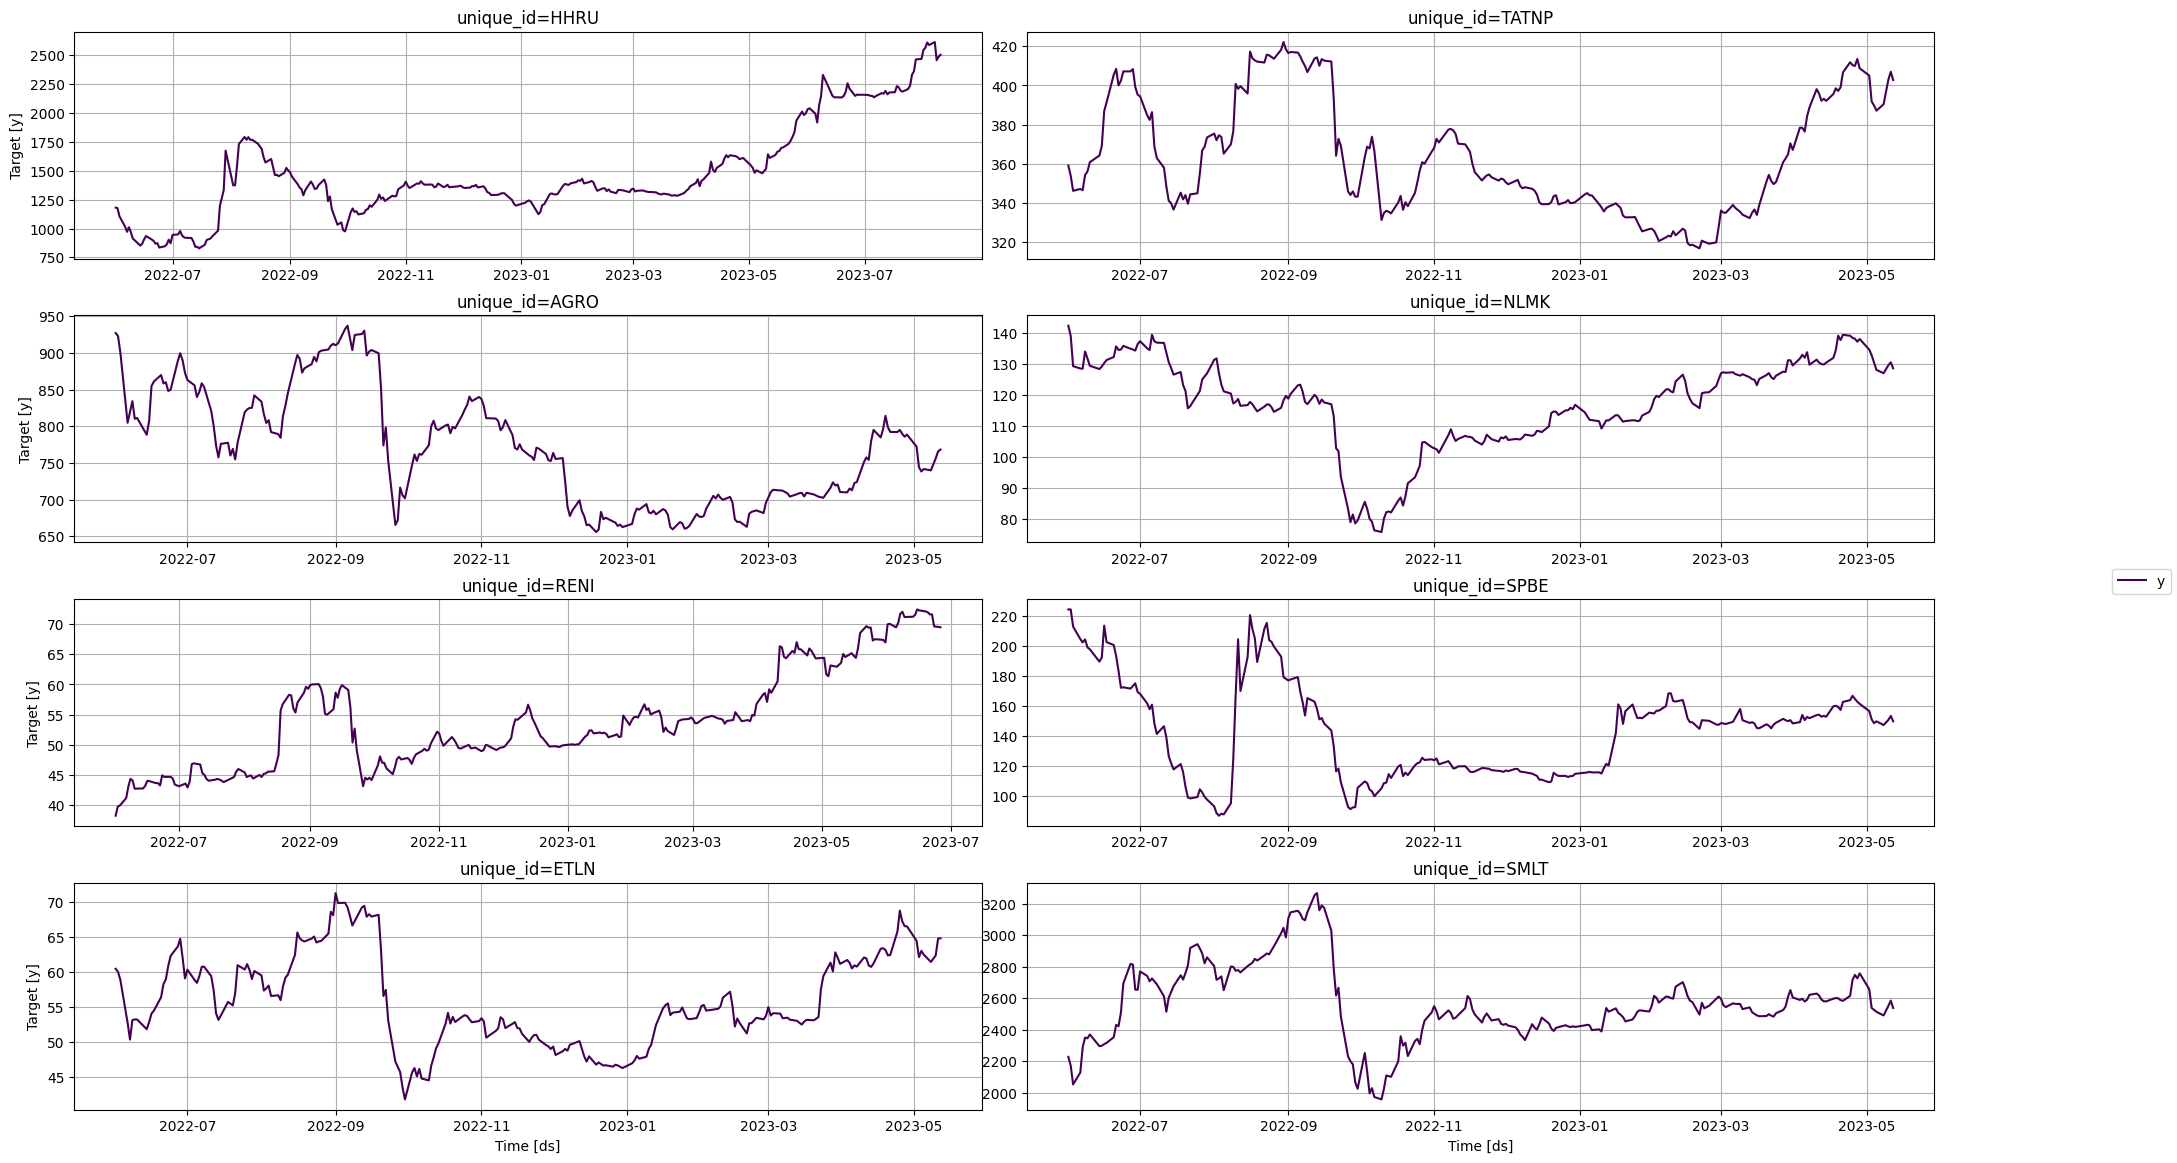

In [15]:
from utilsforecast.plotting import plot_series
fig = plot_series(df)
fig

# Делим на трейн, тест и валидейт

In [16]:
END_TRAIN_DATE = df['ds'].max() - relativedelta(months=6)

In [17]:
train = df.loc[df['ds'] <= END_TRAIN_DATE]
test = df.loc[df['ds'] > END_TRAIN_DATE]

In [18]:
train['ds'].min(), train['ds'].max()

(Timestamp('2022-06-01 00:00:00'), Timestamp('2023-06-08 00:00:00'))

In [19]:
train.head()

,unique_id,ds,y,bigfield_enc
80,AFLT,2022-06-01,28.039904,9
81,AFLT,2022-06-02,27.328365,9
82,AFLT,2022-06-03,26.383654,9
83,AFLT,2022-06-06,26.089423,9
84,AFLT,2022-06-07,26.067115,9


In [20]:
len(train['unique_id'].unique())

95

In [21]:
test['ds'].min(), test['ds'].max()

(Timestamp('2023-06-09 00:00:00'), Timestamp('2023-12-08 00:00:00'))

In [22]:
len(test['unique_id'].unique())

22

# Модели

## MLForecast

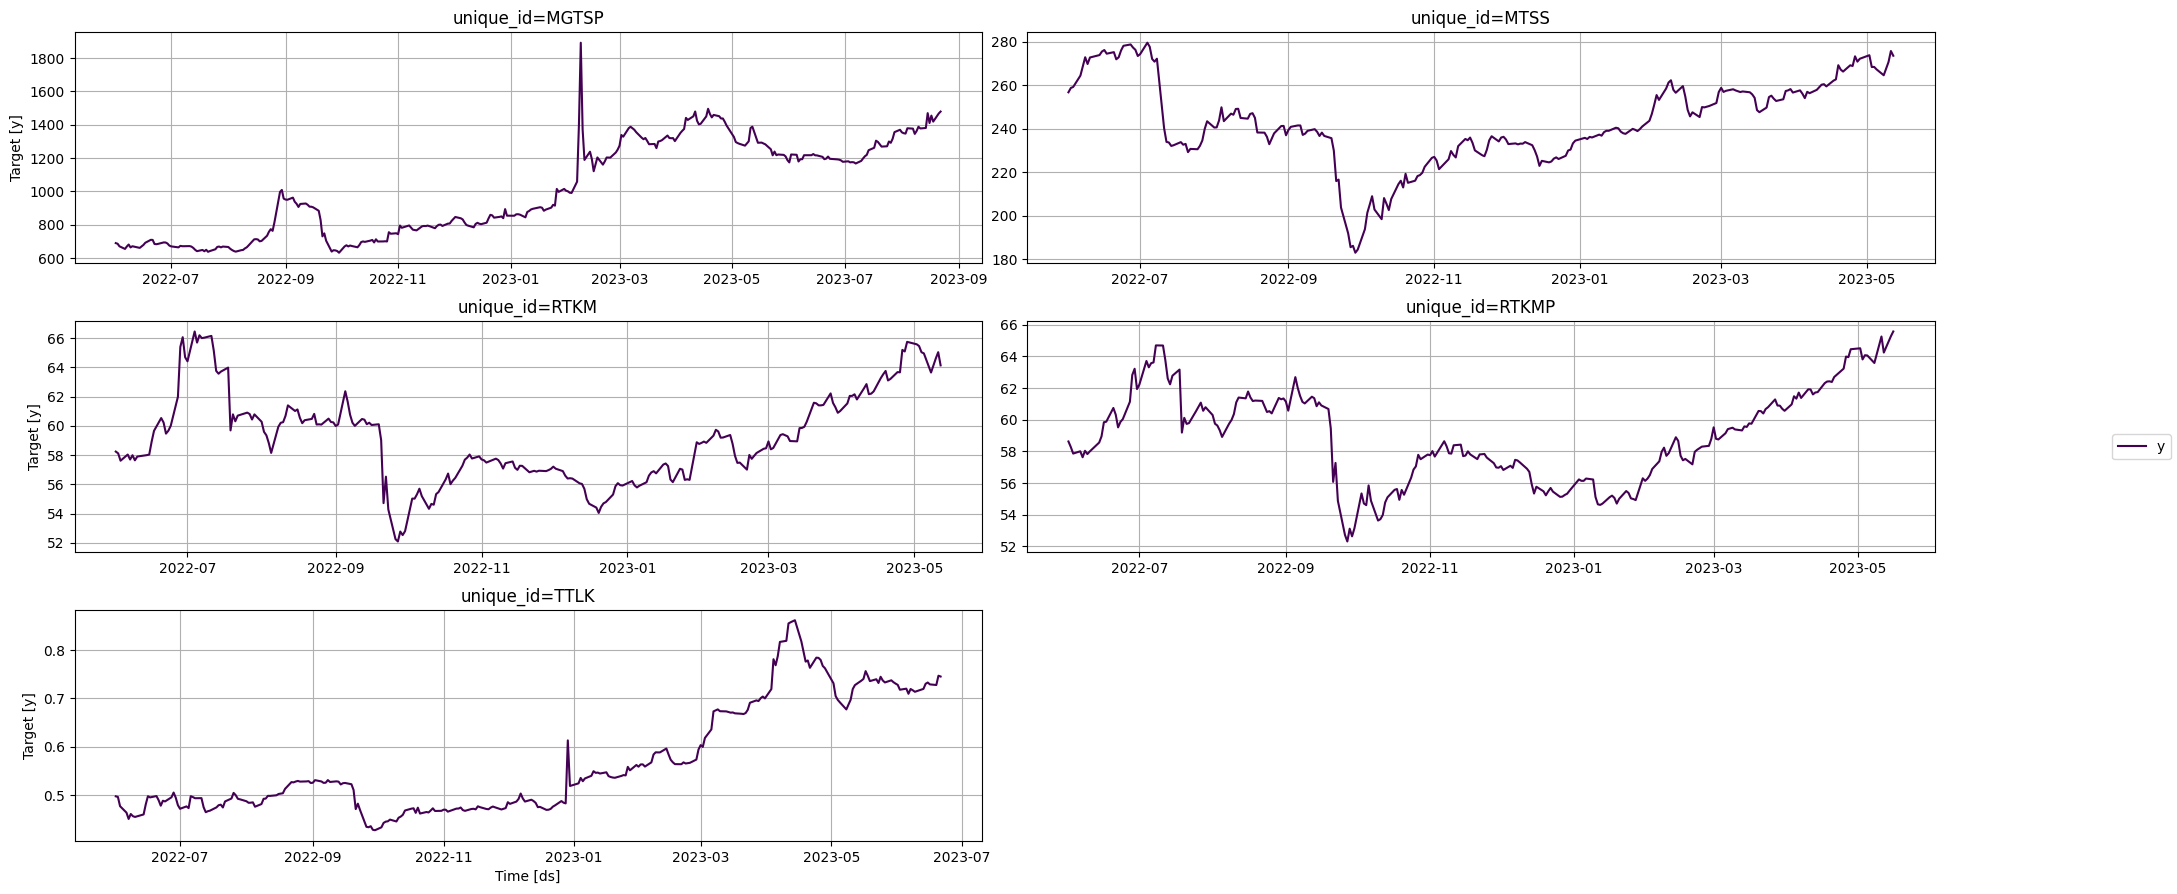

In [23]:
fig = plot_series(df[df['bigfield_enc'] == 5])
fig

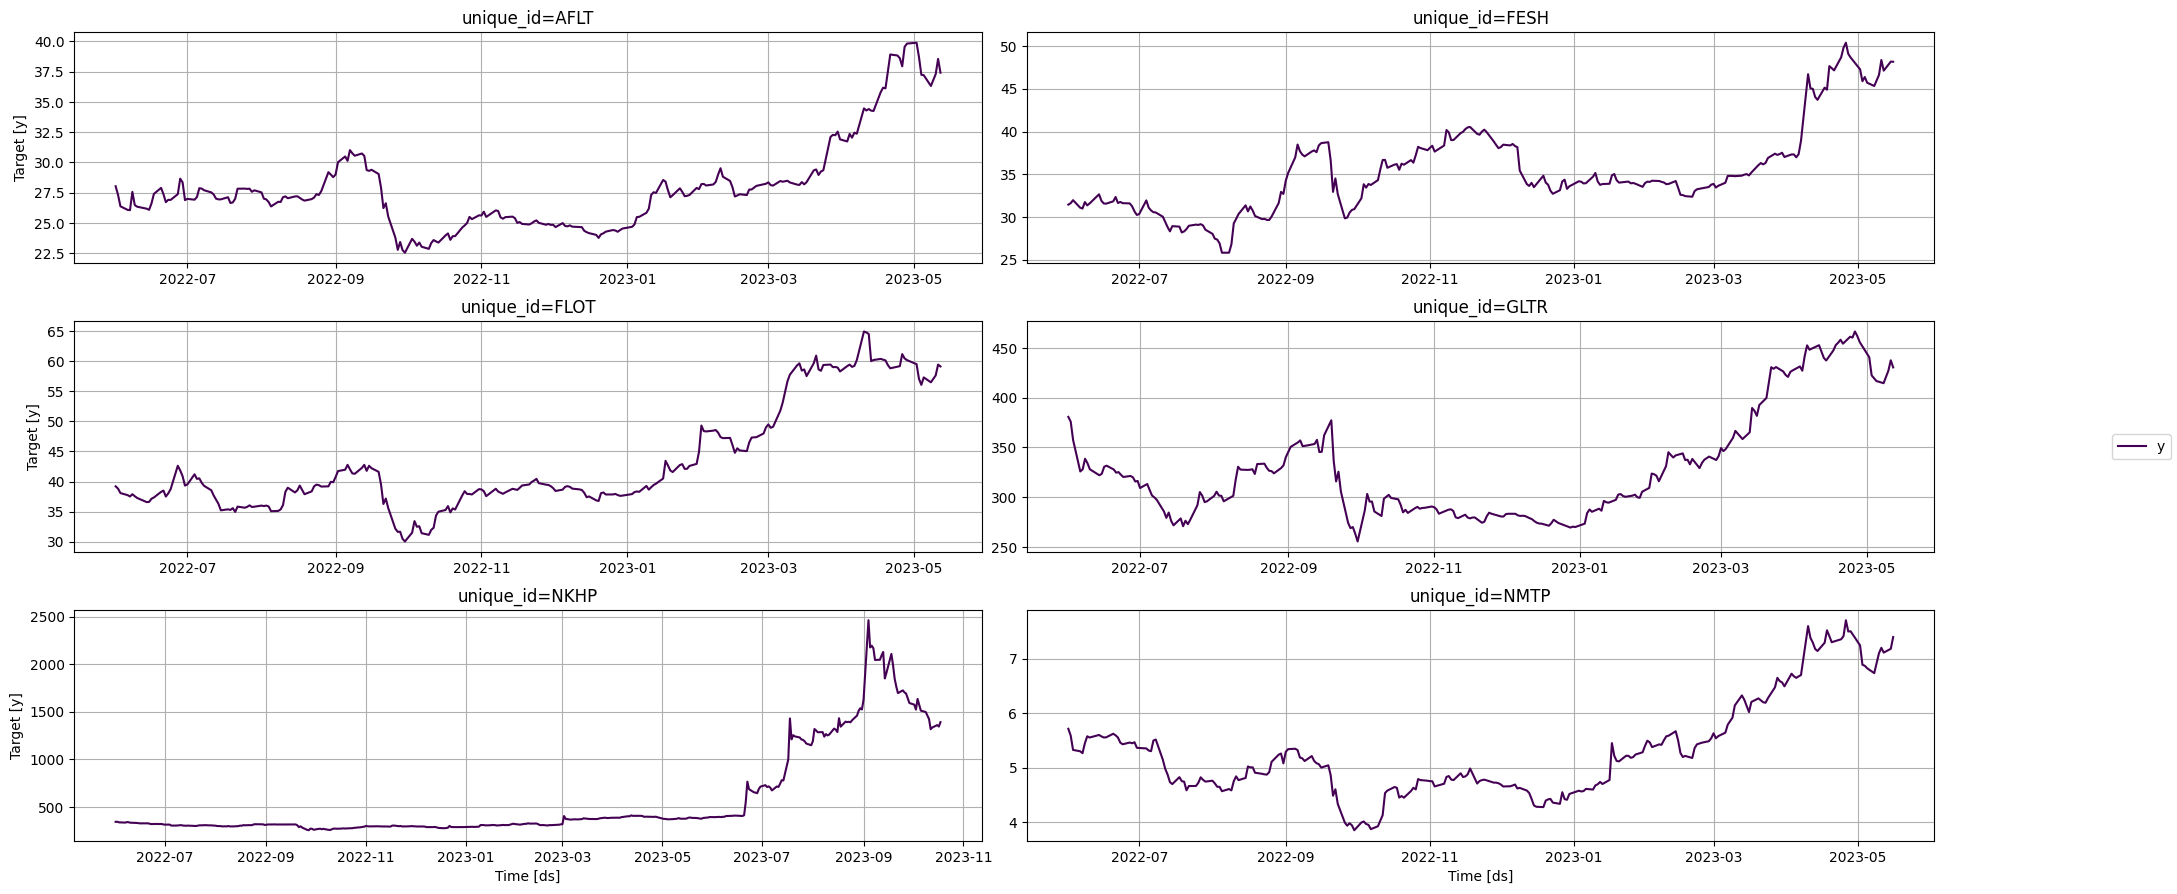

In [24]:
fig = plot_series(df[df['bigfield_enc'] == 9])
fig

In [25]:
def even_day(dates):
    """Day of month is even"""
    return dates.day % 2 == 0

def month_start_or_end(dates):
    """Date is month start or month end"""
    return dates.is_month_start | dates.is_month_end

def is_monday(dates):
    """Date is monday"""
    return dates.dayofweek == 0

def is_sunday(dates):
    """Date is monday"""
    return dates.dayofweek == 6

def is_saturday(dates):
    """Date is monday"""
    return dates.dayofweek == 5

@njit
def ratio_over_previous(x, offset=1):
    """Computes the ratio between the current value and its `offset` lag"""
    return x / shift_array(x, offset=offset)

@njit
def diff_over_previous(x, offset=1):
    """Computes the difference between the current value and its `offset` lag"""
    return x - shift_array(x, offset=offset)

In [26]:
@njit
def rolling_mean_5(x):
    return rolling_mean(x, window_size=5)
@njit
def rolling_mean_10(x):
    return rolling_mean(x, window_size=10)
@njit
def rolling_mean_15(x):
    return rolling_mean(x, window_size=15)

@njit
def rolling_mean_25(x):
    return rolling_mean(x, window_size=25)

@njit
def rolling_mean_35(x):
    return rolling_mean(x, window_size=35)

fcst = MLForecast(
    models=[lgb.LGBMRegressor(force_col_wise=True)],
    date_features=['dayofweek', 'dayofyear', even_day,
                   month_start_or_end, is_monday,
                   is_sunday, is_saturday],
    freq='D',
    target_transforms=[Differences([1]), LocalStandardScaler()],
    lag_transforms={
        1: [expanding_mean,ratio_over_previous, (ratio_over_previous, 2)],
        5: [(rolling_mean, 5), rolling_mean_5],
        10: [(rolling_mean, 10), rolling_mean_10],
        15: [(rolling_mean, 15), rolling_mean_15],
        25: [(rolling_mean, 25), rolling_mean_25],
        35: [(rolling_mean, 25), rolling_mean_25]
    },
)
fcst.fit(train)
# prep = fcst.preprocess(train)


/usr/local/lib/python3.10/dist-packages/mlforecast/core.py:409: UserWarning: The following series were dropped completely due to the transformations and features: ['ELFV'].
These series won't show up if you use `MLForecast.forecast_fitted_values()`.
You can set `dropna=False` or use transformations that require less samples to mitigate this
  warnings.warn(


[LightGBM] [Info] Total Bins 3537
[LightGBM] [Info] Number of data points in the train set: 17360, number of used features: 19
[LightGBM] [Info] Start training from score 0.010021


MLForecast(models=[LGBMRegressor], freq=D, lag_features=['expanding_mean_lag1', 'ratio_over_previous_lag1', 'ratio_over_previous_lag1_offset2', 'rolling_mean_lag5_window_size5', 'rolling_mean_5_lag5', 'rolling_mean_lag10_window_size10', 'rolling_mean_10_lag10', 'rolling_mean_lag15_window_size15', 'rolling_mean_15_lag15', 'rolling_mean_lag25_window_size25', 'rolling_mean_25_lag25', 'rolling_mean_lag35_window_size25', 'rolling_mean_25_lag35'], date_features=['dayofweek', 'dayofyear', <function even_day at 0x786722b96830>, <function month_start_or_end at 0x786722b96a70>, <function is_monday at 0x786722b968c0>, <function is_sunday at 0x786722b96950>, <function is_saturday at 0x78671ee5c5e0>], num_threads=1)

In [27]:
preds = fcst.predict(10*30)
preds

/usr/local/lib/python3.10/dist-packages/mlforecast/core.py:588: UserWarning: Found null values in rolling_mean_lag35_window_size25, rolling_mean_25_lag35.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
/usr/local/lib/python3.10/dist-packages/mlforecast/core.py:588: UserWarning: Found null values in rolling_mean_lag35_window_size25, rolling_mean_25_lag35.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
/usr/local/lib/python3.10/dist-packages/mlforecast/core.py:588: UserWarning: Found null values in rolling_mean_lag35_window_size25, rolling_mean_25_lag35.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
/usr/local/lib/python3.10/dist-packages/mlforecast/core.py:588: UserWarning: Found null values in rolling_mean_lag35_window_size25, rolling_mean_25_lag35.
  warnings.warn(f'Found null values in {", ".join(cols_with_nulls)}.')
/usr/local/lib/python3.10/dist-packages/mlforecast/core.py:588: UserWarning: Found null values i

,unique_id,ds,LGBMRegressor
0,AFLT,2023-05-13,37.363106
1,AFLT,2023-05-14,37.240262
2,AFLT,2023-05-15,37.562295
3,AFLT,2023-05-16,37.699308
4,AFLT,2023-05-17,37.722739
...,...,...,...
28495,YNDX,2024-03-03,1952.235797
28496,YNDX,2024-03-04,1971.484913
28497,YNDX,2024-03-05,1985.196453
28498,YNDX,2024-03-06,1988.059482


In [28]:
preds['ds'].min(), preds['ds'].max()

(Timestamp('2023-05-13 00:00:00'), Timestamp('2024-04-03 00:00:00'))

In [29]:
preds.to_csv('preds.csv')

In [30]:
preds

,unique_id,ds,LGBMRegressor
0,AFLT,2023-05-13,37.363106
1,AFLT,2023-05-14,37.240262
2,AFLT,2023-05-15,37.562295
3,AFLT,2023-05-16,37.699308
4,AFLT,2023-05-17,37.722739
...,...,...,...
28495,YNDX,2024-03-03,1952.235797
28496,YNDX,2024-03-04,1971.484913
28497,YNDX,2024-03-05,1985.196453
28498,YNDX,2024-03-06,1988.059482


In [31]:
pred_vals = preds.merge(test, on=['unique_id', 'ds'])

In [32]:
pred_vals['LGBMRegressor_1'] = pred_vals.groupby(['unique_id'])['LGBMRegressor'].shift(1)


In [33]:
pred_vals['y_1'] = pred_vals.groupby(['unique_id'])['y'].shift(1)


In [34]:
pred_vals['ds'].min(), pred_vals['ds'].max()

(Timestamp('2023-06-09 00:00:00'), Timestamp('2023-12-08 00:00:00'))

In [35]:
pred_vals['koef_pred'] = pred_vals['LGBMRegressor_1']/pred_vals['y']
pred_vals['koef_pred_bin'] = pred_vals['koef_pred'].map(lambda x: 1 if x>=1 else 0)

In [36]:
pred_vals['koef_fact'] = pred_vals['y_1']/pred_vals['y']
pred_vals['koef_fact_bin'] = pred_vals['koef_fact'].map(lambda x: 1 if x>=1 else 0)

In [37]:
pred_vals.head()

,unique_id,ds,LGBMRegressor,y,bigfield_enc,LGBMRegressor_1,y_1,koef_pred,koef_pred_bin,koef_fact,koef_fact_bin
0,AKRN,2023-06-09,18977.699036,18952.625000,7,NaN,NaN,NaN,0,NaN,0
1,AKRN,2023-06-13,19057.066337,19064.471264,7,18977.699036,18952.625000,0.995448,0,0.994133,0
2,AKRN,2023-06-14,19083.940502,18891.489362,7,19057.066337,19064.471264,1.008765,1,1.009157,1
3,AKRN,2023-06-15,19121.587310,18835.305882,7,19083.940502,18891.489362,1.013200,1,1.002983,1
4,AKRN,2023-06-16,19143.009638,18836.476744,7,19121.587310,18835.305882,1.015136,1,0.999938,0


In [38]:
pred_vals = pred_vals[['unique_id','ds',
                      'koef_pred_bin',
                      'koef_fact_bin']].merge(tradestats[['trade_code', 'bigfield_enc', 'bigfield']],
                            left_on ='unique_id',
                            right_on ='trade_code')

In [39]:
pred_vals['is_correct'] = pred_vals.apply(lambda x: 1 if
                                          x['koef_pred_bin'] == x['koef_fact_bin']
                                          else 0, axis=1)

In [40]:
pred_vals['is_correct'].mean()

0.5534561499896985

In [41]:
pred_vals.groupby('bigfield', as_index=False)\
          .agg({'is_correct':'mean'})\
          .sort_values('is_correct')\
          .rename(columns={'bigfield':'индустрия',
                           'is_correct':'Коэффициент_проходимости_торговой_стратегии '})

,индустрия,Коэффициент_проходимости_торговой_стратегии
8,транспорт,0.462366
1,Металлы и добыча,0.478261
2,Нефтегаз,0.500000
7,Электроэнергетика,0.546702
3,Потребсектор,0.561877
0,ИТ,0.590909
5,Финансы,0.601311
6,Химпром,0.648440
4,Телекоммуникации,0.679660


In [42]:
pred_vals

,unique_id,ds,koef_pred_bin,koef_fact_bin,trade_code,bigfield_enc,bigfield,is_correct
0,AKRN,2023-06-09,0,0,AKRN,7,Химпром,1
1,AKRN,2023-06-09,0,0,AKRN,7,Химпром,1
2,AKRN,2023-06-09,0,0,AKRN,7,Химпром,1
3,AKRN,2023-06-09,0,0,AKRN,7,Химпром,1
4,AKRN,2023-06-09,0,0,AKRN,7,Химпром,1
...,...,...,...,...,...,...,...,...
349459,WUSH,2023-11-27,0,1,WUSH,3,Потребсектор,0
349460,WUSH,2023-11-27,0,1,WUSH,3,Потребсектор,0
349461,WUSH,2023-11-27,0,1,WUSH,3,Потребсектор,0
349462,WUSH,2023-11-27,0,1,WUSH,3,Потребсектор,0


In [43]:
pred_vals[pred_vals['bigfield'] == 'Химпром']['unique_id'].unique()

array(['AKRN', 'KAZT', 'KZOS', 'NKNC'], dtype=object)

In [44]:
df_chart_days = pred_vals.groupby('ds',
                as_index=False)\
        .agg({'is_correct':'mean'})\
        .sort_values('ds')
df_chart_days['ds'] = pd.to_datetime(df_chart_days['ds'])

df_chart_days.set_index('ds', inplace=True)

df_chart_weekly = df_chart_days.resample('W').mean()

df_chart_weekly.reset_index(inplace=True)
df_chart_weekly


,ds,is_correct
0,2023-06-11,1.000000
1,2023-06-18,0.666587
2,2023-06-25,0.582498
3,2023-07-02,0.503210
4,2023-07-09,0.546796
5,2023-07-16,0.475869
6,2023-07-23,0.575858
7,2023-07-30,0.586502
8,2023-08-06,0.641528
9,2023-08-13,0.621900


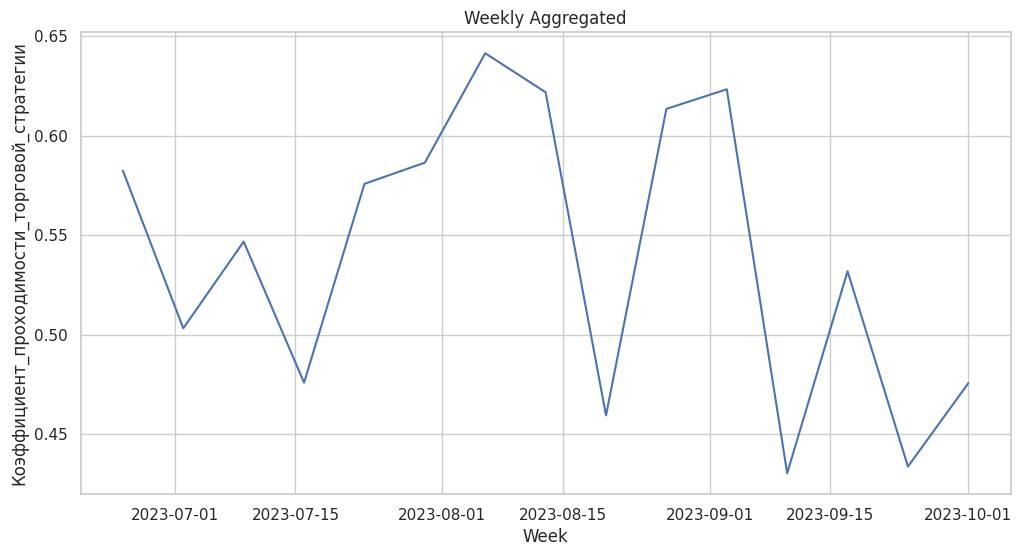

In [45]:
import seaborn as sns
# Рисование графика
sns.set(style="whitegrid")  # Устанавливаем стиль сетки
plt.figure(figsize=(12, 6))  # Устанавливаем размер графика

# Рисуем линейный график
# plt.plot(df_chart_weekly['ds'], df_chart_weekly['is_correct'])
sns.lineplot(x='ds', y='is_correct', data=df_chart_weekly[(df_chart_weekly['ds']<'2023-10-05')&
                                                          (df_chart_weekly['ds']>'2023-06-18')])

# Добавляем заголовок и метки осей
plt.title('Weekly Aggregated')
plt.xlabel('Week')
plt.ylabel('Коэффициент_проходимости_торговой_стратегии')

# Показываем график
plt.show()

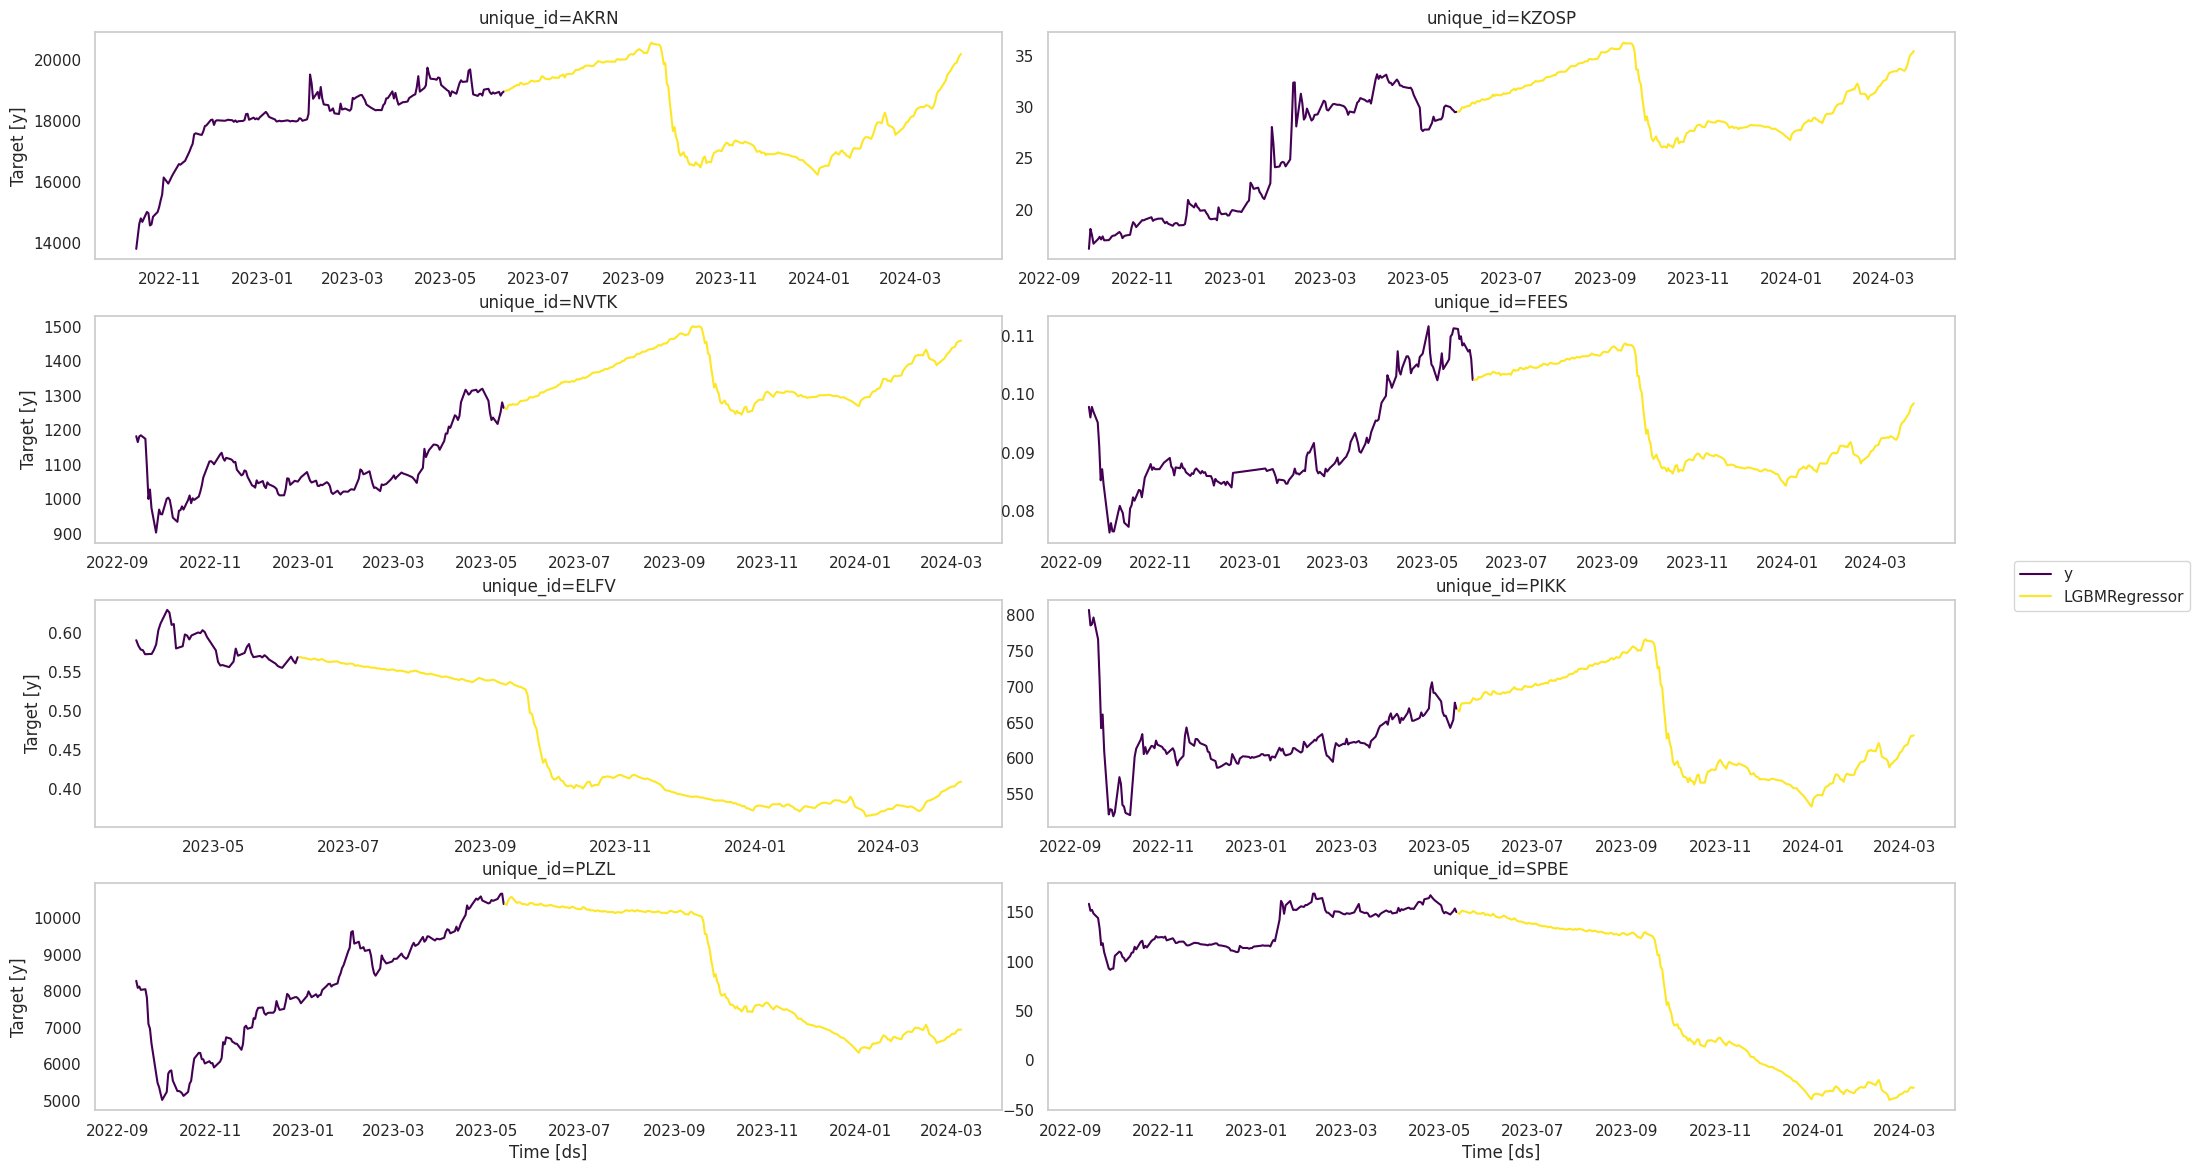

In [46]:
fig = plot_series(train, preds[['unique_id', 'ds', 'LGBMRegressor']], max_insample_length=24 * 7)
fig